In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [12]:
# Base path
BASE_DIR = "/Users/akshatha/GeorgakopoulosSoaresLab/g4_analysis"
SPECIES_DATA = f"{BASE_DIR}/results/species_data.csv"
G4_DIST = f"{BASE_DIR}/results/regex_g4_distribution.csv"
GFF_DATA = f"{BASE_DIR}/results/gff_feature_data.csv"

def get_domain(taxa):
    if taxa == 'viral':
        return 'Virus'
    elif taxa == 'bacteria':
        return 'Bacteria'
    elif taxa == 'archaea':
        return 'Archaea'
    else:
        return 'Eukaryota'    

# set color map for domains
color_map = {
    'Virus': '#66c2a5',
    'Bacteria': '#fc8d62',
    'Eukaryota': '#8da0cb',
    'Archaea': '#e78ac3'
}

In [13]:
# read species data
df_species = pd.read_csv(f"{BASE_DIR}/results/species_data.csv")
df_species = df_species[["Accession", "Genome Size", "GC Percentage", "Taxa", "Kingdom", "Phylum"]]
df_species = df_species.replace('na', np.nan)
df_species["Domain"] = df_species["Taxa"].apply(get_domain)
df_species.set_index('Accession', inplace=True)
# filter out metagenomes and other taxa as they are not relevant for domain level analysis
df_species = df_species[df_species["Taxa"] != "metagenomes"]
df_species = df_species[df_species["Taxa"] != "other"]
# for viruses, set kingdom as virus
df_species.loc[df_species["Taxa"] == "viral", "Kingdom"] = "Virus"

# read g4 distribution data
df_dist = pd.read_csv(G4_DIST)
df_dist.set_index('accession', inplace=True)
df_dist = df_dist[['gene', 'exon', 'CDS', 'total_g4_length', 'g4_count']]
# rename columns
df_dist.columns = ['G4s in Genes', 'G4s in Exons', 'G4s in CDS', 'Total G4 Length', 'G4 Count']

# read gff data
df_gff = pd.read_csv(GFF_DATA)
df_gff.set_index('accession', inplace=True)
df_gff = df_gff[['gene', 'exon', 'CDS']]
# rename columns
df_gff.columns = ['Genes', 'Exons', 'CDS']

# merge dataframes on index (accession)
df_g4 = df_species.join(df_dist, how='inner')
df_g4 = df_g4.join(df_gff, how='inner')
df_g4.reset_index(inplace=True)
df_g4.rename(columns={'index': 'Accession'}, inplace=True)

# drop rows where phylum is NaN as they are not relevant for phylum level analysis
df_g4.dropna(subset=['Phylum'], inplace=True)

df_g4.head()

,Accession,Genome Size,GC Percentage,Taxa,Kingdom,Phylum,Domain,G4s in Genes,G4s in Exons,G4s in CDS,Total G4 Length,G4 Count,Genes,Exons,CDS
0,GCA_000002515.1,10689156,38.5,fungi,Fungi,Ascomycota,Eukaryota,126.0,NaN,126.0,890,36,7509678.0,35663.0,7394184.0
1,GCA_000002765.3,23292622,19.0,protozoa,Protista,Apicomplexa,Eukaryota,267.0,NaN,297.0,20268,837,13658969.0,118336.0,12451712.0
2,GCA_000006645.1,4701745,47.5,bacteria,Eubacteria,Pseudomonadota,Bacteria,1346.0,NaN,1346.0,1652,66,3916203.0,39060.0,3878552.0
3,GCA_000006605.1,2476822,61.0,bacteria,Eubacteria,Actinomycetota,Bacteria,2742.0,NaN,2742.0,4017,154,2232019.0,18704.0,2209637.0
4,GCA_000006685.1,1080451,40.0,bacteria,Eubacteria,Chlamydiota,Bacteria,87.0,NaN,87.0,87,3,988387.0,12072.0,967121.0


In [14]:
# calculate G4 densities by feature
df_g4['G4 Density per Mb: Genome'] = df_g4['Total G4 Length']/df_g4['Genome Size'] * 1000000
df_g4['G4 Density per Mb: Gene'] = df_g4['G4s in Genes']/df_g4['Genes'] * 1000000
df_g4['G4 Density per Mb: Exon'] = df_g4['G4s in Exons']/df_g4['Exons'] * 1000000
df_g4['G4 Density per Mb: CDS'] = df_g4['G4s in CDS']/df_g4['CDS'] * 1000000
df_g4.head(100)
df_g4.to_csv(f'{BASE_DIR}/results/regex_combined_dist_data.csv', index=False)

In [15]:
# group by domain and get mean of all columns starting with "Type:"
df_domain = df_g4.groupby('Domain').agg(
    {col: 'mean' for col in df_g4.columns if col.startswith('G4 Density per Mb: ')}
)
df_domain.head()

,G4 Density per Mb: Genome,G4 Density per Mb: Gene,G4 Density per Mb: Exon,G4 Density per Mb: CDS
Domain,,,,
Archaea,634.562502,598.475694,6615.573831,592.031014
Bacteria,743.597594,694.355027,2742.114530,700.122648
Eukaryota,1889.295327,1407.122960,1293.885495,1182.438242
Virus,1642.491158,3597.392445,29403.784733,4409.507422


In [16]:
# create new dataframe for grouped domain plots
df_domain_plot = df_g4[['Domain', 'G4 Density per Mb: Genome', 'G4 Density per Mb: Gene', 'G4 Density per Mb: Exon', 'G4 Density per Mb: CDS']]
df_domain_plot = df_domain_plot.melt(id_vars=['Domain'], var_name='Feature', value_name='G4 Density per Mb')
# extract genomic feature from the column name
df_domain_plot['Feature'] = df_domain_plot['Feature'].apply(lambda x: x.split(': ')[1])
df_domain_plot.head()

,Domain,Feature,G4 Density per Mb
0,Eukaryota,Genome,83.261953
1,Eukaryota,Genome,870.146779
2,Bacteria,Genome,351.358910
3,Bacteria,Genome,1621.836369
4,Bacteria,Genome,80.521930


<Figure size 1000x1000 with 0 Axes>

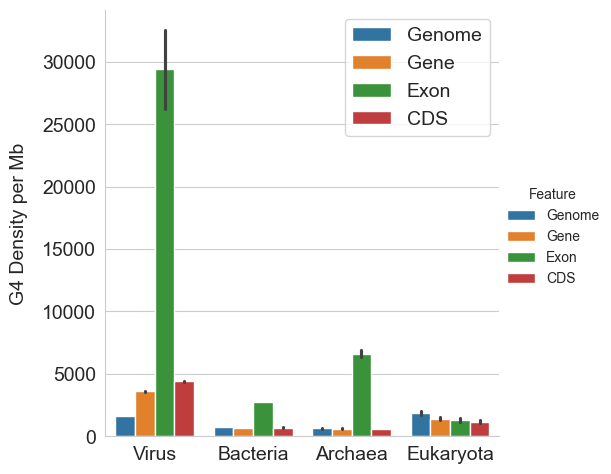

In [26]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 10))

sns.catplot(
    data=df_domain_plot, 
    kind="bar",
    x="Domain", 
    y="G4 Density per Mb", 
    hue="Feature",
    order=["Virus", "Bacteria", "Archaea", "Eukaryota"],
    errorbar="se"
)
# formatting
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('')
plt.ylabel('G4 Density per Mb', fontsize=14, labelpad=10)
plt.savefig(f'{BASE_DIR}/plots/feature_domain_g4_density_regex.png') 

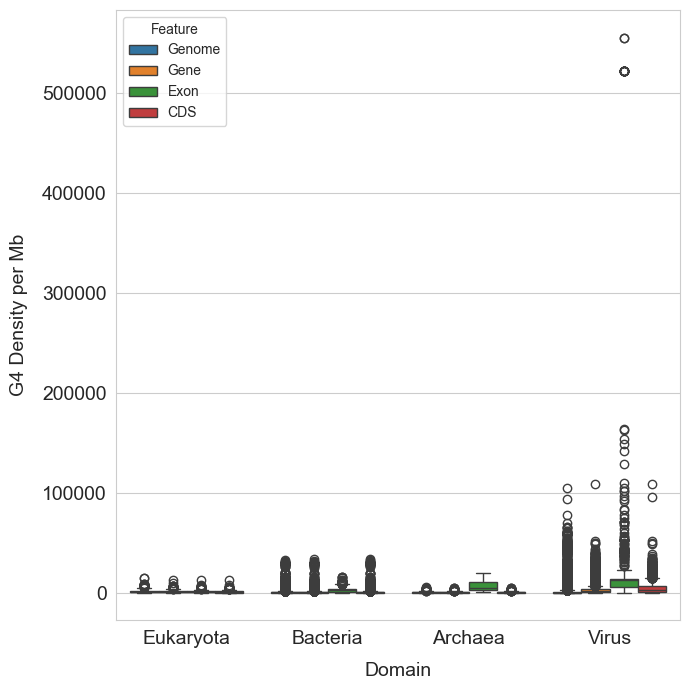

In [18]:
sns.set_style("whitegrid")
plt.figure(figsize=(7, 7))

sns.boxplot(
    data=df_domain_plot, 
    x="Domain", 
    y="G4 Density per Mb", 
    hue="Feature"
)

# formatting
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Domain', fontsize=14, labelpad=10)
plt.ylabel('G4 Density per Mb', fontsize=14, labelpad=10)
plt.tight_layout()

In [19]:
# create new dataframe for grouped phylum plots
df_phylum_plot = df_g4[['Domain', 'Kingdom', 'Phylum', 'G4 Density per Mb: Genome', 'G4 Density per Mb: Gene', 'G4 Density per Mb: Exon', 'G4 Density per Mb: CDS']]
df_phylum_plot = df_phylum_plot.melt(id_vars=['Domain', 'Kingdom', 'Phylum'], var_name='Feature', value_name='G4 Density per Mb')
# extract genomic feature from the column name
df_phylum_plot['Feature'] = df_phylum_plot['Feature'].apply(lambda x: x.split(': ')[1])
df_heatmap = df_phylum_plot.pivot_table(index=['Domain', 'Phylum'], columns=['Feature'], values='G4 Density per Mb', aggfunc='mean')
df_heatmap.fillna(0, inplace=True)
df_heatmap = df_heatmap.apply(lambda x: np.log10(x+1))
df_heatmap = df_heatmap[['Genome', 'Gene', 'Exon', 'CDS']]
# filter rows with less than 5 species
df_phylum_count = df_phylum_plot.pivot_table(index=['Domain', 'Kingdom', 'Phylum'], values='G4 Density per Mb', aggfunc='count')
df_phylum_count.rename(columns={'G4 Density per Mb': 'Count'}, inplace=True)
df_heatmap = df_heatmap.join(df_phylum_count, how='inner')
df_heatmap = df_heatmap[df_heatmap['Count'] >= 5]
df_heatmap.drop(columns=['Count'], inplace=True)
df_heatmap.head()

Genome      Gene  \
Domain  Phylum                       Kingdom                               
Archaea Candidatus Heimdallarchaeota Archaeabacteria  1.172749  1.221731   
        Candidatus Lokiarchaeota     Archaeabacteria  1.673382  1.630539   
        Candidatus Micrarchaeota     Archaeabacteria  2.215480  2.215078   
        Candidatus Nanohaloarchaeota Archaeabacteria  1.769169  1.758419   
        Candidatus Thermoplasmatota  Archaeabacteria  2.520221  2.515297   

                                                          Exon       CDS  
Domain  Phylum                       Kingdom                              
Archaea Candidatus Heimdallarchaeota Archaeabacteria  0.000000  1.221443  
        Candidatus Lokiarchaeota     Archaeabacteria  0.000000  1.631480  
        Candidatus Micrarchaeota     Archaeabacteria  3.561725  2.313070  
        Candidatus Nanohaloarchaeota Archaeabacteria  3.237227  1.723337  
        Candidatus Thermoplasmatota  Archaeabacteria  3.605380  2.507517

/var/folders/qb/4ylt6z0d6tb4k4dfqtp35dbh0000gn/T/ipykernel_33276/1542904429.py:32: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


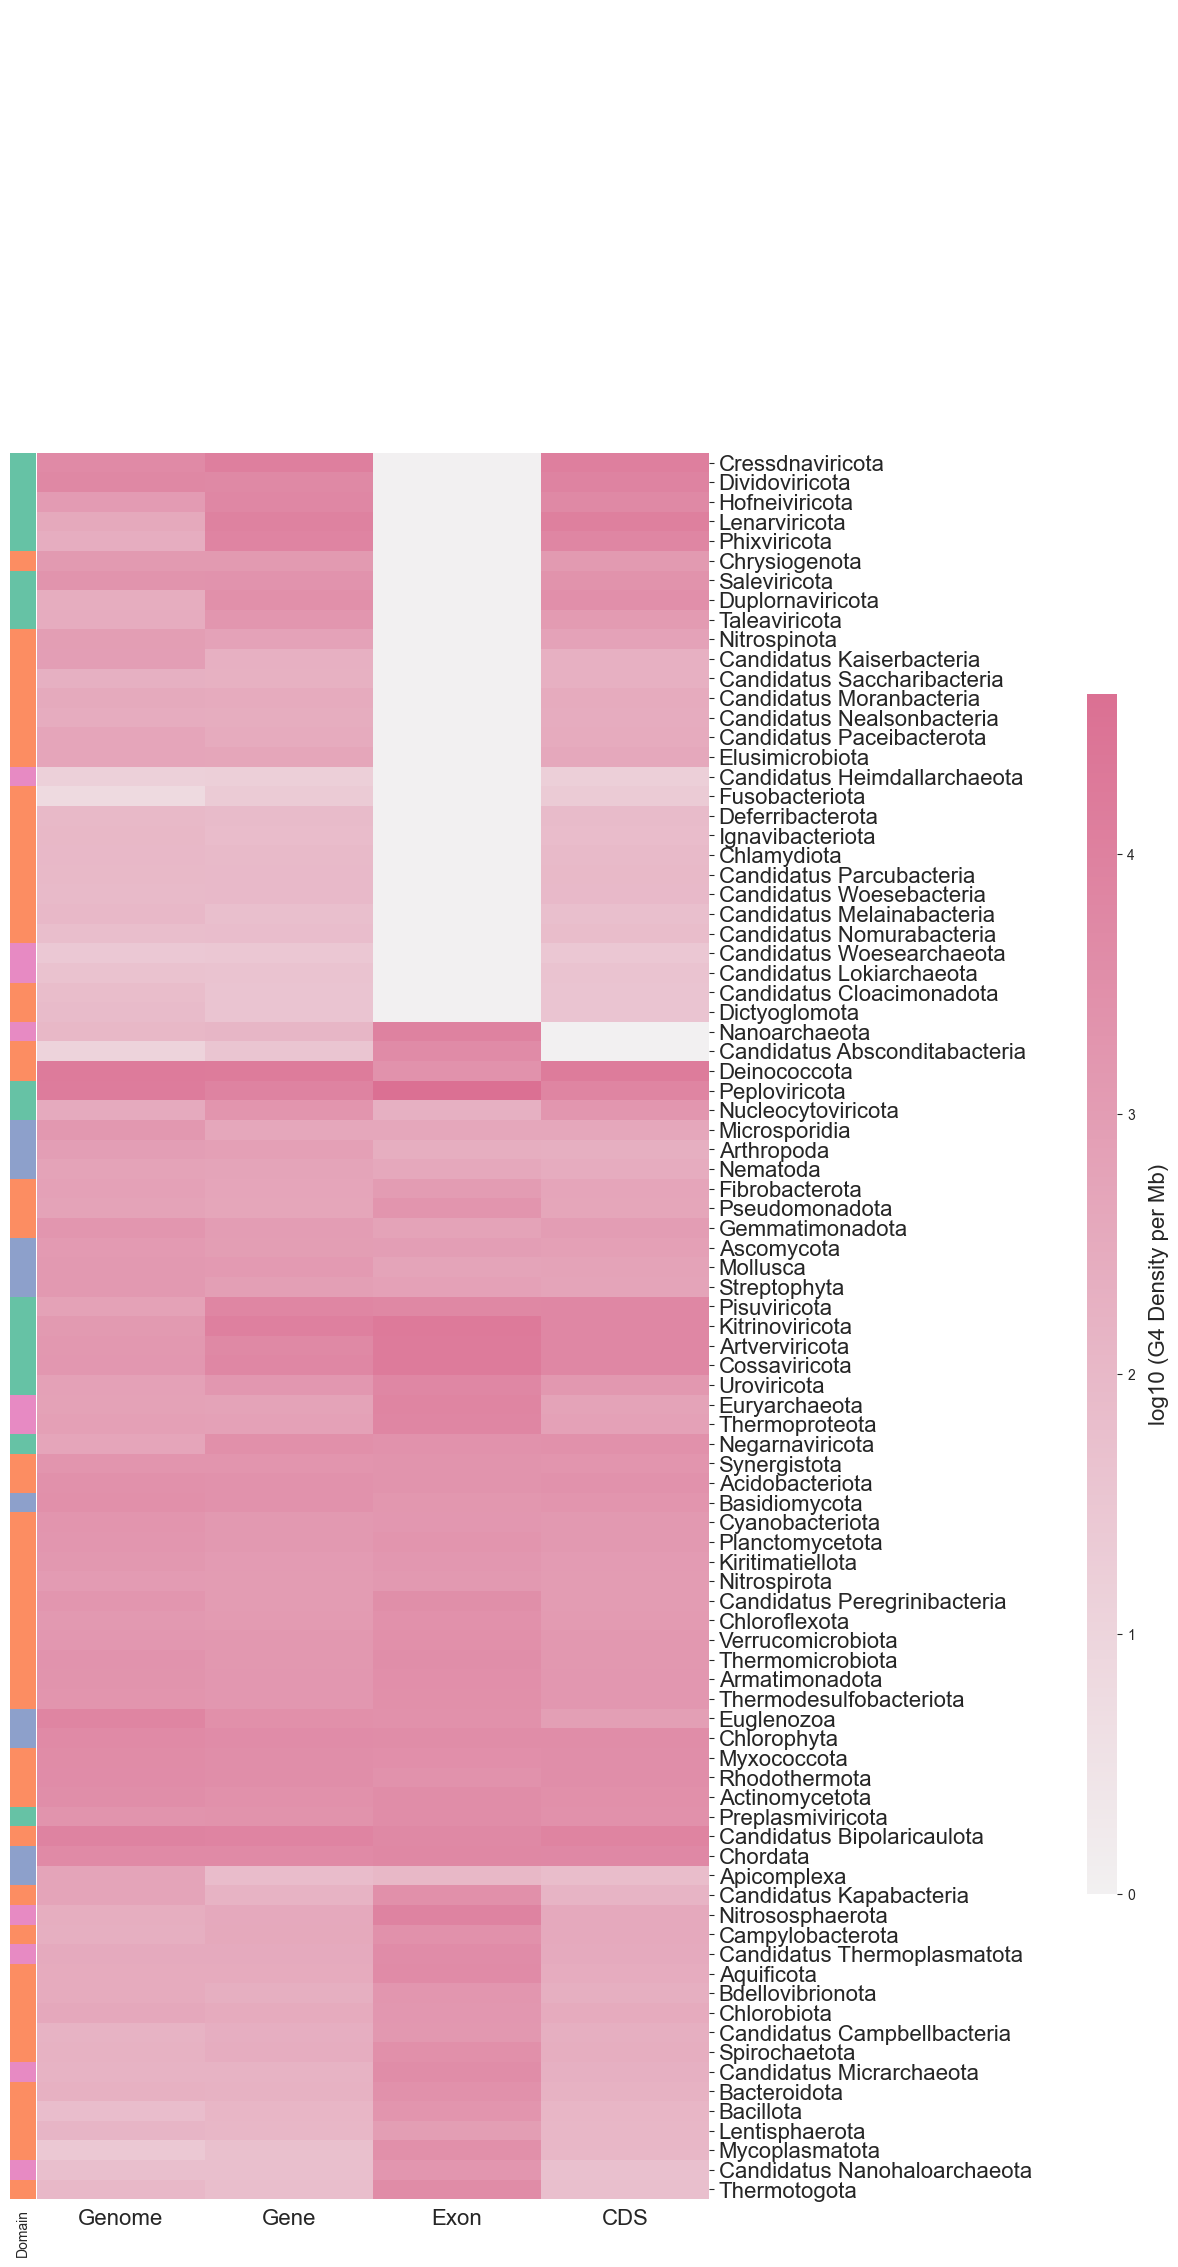

In [31]:
# clustermap with phylum on y-axis and genomic feature on x-axis
domains = df_heatmap.index.get_level_values("Domain")
domain_colors = pd.Series(domains, index=df_heatmap.index).map(color_map)

# create a cmap with palevioletred
cmap = sns.light_palette("palevioletred", as_cmap=True)

g = sns.clustermap(
    df_heatmap,
    xticklabels=True,
    yticklabels=True,
    col_cluster=False,
    row_cluster=True,
    row_colors=domain_colors,
    cmap=cmap,
)
# hide dendrograms
g.ax_row_dendrogram.set_visible(False)

# formatting labels
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=16)
ylabels = [str(x).split('-')[1].replace("')", "") for x in g.ax_heatmap.get_yticklabels()]
g.ax_heatmap.set_yticklabels(ylabels, fontsize=16)

# set colorbar position
plt.gcf().axes[-1].set_position([0.85, 0.2, .02, .5])
plt.gcf().axes[-1].set_ylabel('log10 (G4 Density per Mb)', labelpad=10, fontsize=16)
plt.gcf().set_size_inches(15, 24)

plt.tight_layout()
plt.savefig(f'{BASE_DIR}/plots/feature_vs_phylum_g4_density_regex.png', bbox_inches='tight')